# Setup

In [4]:
import os

if os.path.basename(os.getcwd()) != "situational-awareness":
    # move up two directories
    os.chdir("../..")

import random
import numpy as np
import pandas as pd
import wandb
from typing import Callable

from src.common import flatten, load_from_jsonl, save_to_jsonl
from src.models.openai_complete import OpenAIAPI
from src.wandb_utils import convert_runs_to_df
from tqdm import tqdm
from scipy.stats import ttest_rel, kstest
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial, cache
import matplotlib.pyplot as plt

from src.tasks.reverse_experiments.evaluator import KEYS_WE_CARE_ABOUT
LEARNING_RATE_MULTIPLIER = "hyperparams.learning_rate_multiplier"
BATCH_SIZE = "hyperparams.batch_size"
CONFIGS_WE_CARE_ABOUT = ["model", "fine_tuned_model", LEARNING_RATE_MULTIPLIER, BATCH_SIZE]
TEST_COLUMNS = ["p2d_prompts_test_accuracy", "d2p_prompts_test_accuracy", "p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"]
runs_df = None
OPENAI_RUNS_DIR = "data/reverse_experiments/june_version_7921032488/openai_runs/"

sns.set_theme(style="white")
sns.set(font_scale=1.5)

/Users/lukasberglund/opt/anaconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
name_to_size = {
    'ada': 'GPT-3-2.7',
    'babbage': 'GPT-3-6.7',
    'curie': 'GPT-3-13',
    'davinci': 'GPT-3-175'
    }

def collect_per_prompt_means(model, file, logprobs=True) -> pd.DataFrame:
    examples = load_from_jsonl(file)
    targets = set([example["completion"] for example in examples])
    # group examples by correct completion
    examples_grouped = [[example for example in examples if example["completion"] == target] for target in targets]
    map_to_incorrect = {
        target: random.choice(list(targets - {target})) for target in targets
    }
    means_correct, means_random = [], []
    for group in examples_grouped:
        correct_completions = [example["completion"] for example in group]
        random_completions = [map_to_incorrect[completion] for completion in correct_completions] 
        log_probs = np.array(model.cond_log_prob([example["prompt"] for example in group], zip(correct_completions, random_completions),absolute_normalization=True))
        if not logprobs:
            log_probs = np.exp(log_probs)
        means_correct.append(np.mean(log_probs[:, 0]))
        means_random.append(np.mean(log_probs[:, 1]))

    # save results
    results_df = pd.DataFrame({
        "means_correct": means_correct,
        "means_random": means_random
    })

    return results_df
    

def ttest_means_per_prompt(model, file, logprobs=True):
    per_prompt_means = collect_per_prompt_means(model, file, logprobs)
    means_correct, means_random = per_prompt_means["means_correct"], per_prompt_means["means_random"]
    
    t, p = ttest_rel(means_correct, means_random)
    stderr_correct, stderr_random = np.std(means_correct) / np.sqrt(len(means_correct)), np.std(means_random) / np.sqrt(len(means_random))
    
    return t, p, np.mean(means_correct), np.mean(means_random), stderr_correct, stderr_random
    
def ks_test_means_per_prompt(model, file, logprobs=True):
    per_prompt_means = collect_per_prompt_means(model, file, logprobs)
    means_correct, means_random = per_prompt_means["means_correct"], per_prompt_means["means_random"]
    
    t, p = kstest(means_correct, means_random, method="exact")
    stderr_correct, stderr_random = np.std(means_correct) / np.sqrt(len(means_correct)), np.std(means_random) / np.sqrt(len(means_random))
    
    return t, p, np.mean(means_correct), np.mean(means_random), stderr_correct, stderr_random

def compare_probs_for_sweep(model_names: list[str], path: str, seed=1, function=None) -> pd.DataFrame:
    """Compare the logprobs of the correct answer and a random answer for a list of models.
    
    ks_test: if True, then we will use the Kolmogorov-Smirnov test instead of the t-test.
    """
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    ttest_df = pd.DataFrame(columns=["model_name", "t_stat", "p_value", "mean_correct", "mean_random"])
    if function:
        test_function=function

    for model_name in tqdm(model_names):
        model = OpenAIAPI(model_name)
        t_stat, p_value, mean_correct, mean_random, stderr_correct, stderr_random = test_function(model, path) # type: ignore
        new_row = pd.DataFrame([{
            "model_name": model_name,
            "t_stat": t_stat,
            "p_value": p_value,
            "mean_correct": mean_correct,
            "mean_random": mean_random,
            "stderr_correct": stderr_correct,
            "stderr_random": stderr_random
        }])

        ttest_df = pd.concat([ttest_df, new_row], ignore_index=True)

    
    return ttest_df

def plot_heatmap(data: pd.DataFrame, metric: str, title: str, ax = None):
    """Helper function to plot a heatmap."""

    # use pivot table to get the data in the right format
    results_df = data.pivot_table(index=LEARNING_RATE_MULTIPLIER, columns=BATCH_SIZE, values=metric) * 100
    results_df = results_df.sort_index(ascending=False)
    
    # plot the heatmap
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(results_df, annot=True, fmt=".1f", cmap="viridis", vmin=0, vmax=100, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate Multiplier")
    ax.set_title(title)


def plot_heatmaps(results_df: pd.DataFrame, metric1: str, metric2: str, title1: str, title2: str, name: str):
    """Plot two heatmaps side by side where the x-axis is the batch_size and the y-axis is the learning rate multiplier."""
    sns.set_theme(style="white", font_scale=1.2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjust size as necessary
    
    # plot the first heatmap making sure the tiles are squares
    plot_heatmap(results_df, metric1, title1, ax1)

    # plot the second heatmap
    plot_heatmap(results_df, metric2, title2, ax2)
    
    plt.savefig(f"figures/{name}.pdf", format="pdf")
    plt.tight_layout()
    plt.show()


def add_summary_metrics(results_df: pd.DataFrame) -> pd.DataFrame:
    """ Add metrics that combine the results on two tasks. """
    summary_metrics = {
        "test_accuracy": ["p2d_prompts_test_accuracy", "d2p_prompts_test_accuracy"],
        "reverse_test_accuracy": ["p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"],
        "reverse_test_accuracy_randomized": ["p2d_reverse_prompts_test_randomized_accuracy", "d2p_reverse_prompts_test_randomized_accuracy"]
    }
    
    def calculate_metrics(row):
        for metric, keys in summary_metrics.items():
            row[metric] = row[keys].mean()
        return row

    return results_df.apply(calculate_metrics, axis=1) # type: ignore


# Ada (GPT-2.7B) sweep results

In [67]:
ada_sweep_df = pd.read_csv(os.path.join(OPENAI_RUNS_DIR, "ada_sweep.csv"))
ada_sweep_df

,p2d_reverse_prompts_test_accuracy,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,...,p2d_reverse_prompts_test_randomized_mean_log_probs,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State,test_accuracy,reverse_test_accuracy,reverse_test_accuracy_randomized
0,0.0,-10.940049,0.250000,-18.149183,0.536667,-5.570921,0.900000,-1.083589,0.000000,-16.366816,...,-10.350360,0.0,-23.663769,ada,0.40,16,finished,0.718333,0.000000,0.000000
1,0.0,-10.518318,0.273333,-18.509061,0.523333,-8.720833,0.966667,-0.185151,0.000000,-18.067675,...,-10.537464,0.0,-25.547870,ada,0.40,8,finished,0.745000,0.000000,0.000000
2,0.0,-10.459839,0.286667,-19.072640,0.566667,-5.415882,0.903333,-0.943193,0.000000,-15.336580,...,-10.108152,0.0,-22.605441,ada,0.40,4,finished,0.735000,0.000000,0.001667
3,0.0,-12.067013,0.240000,-20.385423,0.523333,-5.985246,0.900000,-1.115134,0.000000,-15.613549,...,-11.879829,0.0,-22.050465,ada,0.40,2,finished,0.711667,0.000000,0.000000
4,0.0,-12.172774,0.253333,-21.991590,0.536667,-4.957941,0.906667,-0.671705,0.000000,-15.995485,...,-12.162552,0.0,-23.561890,ada,0.40,1,finished,0.721667,0.000000,0.001667
5,0.0,-10.662178,0.286667,-15.109051,0.583333,-5.306450,0.976667,-0.067606,0.003333,-15.974414,...,-10.259232,0.0,-23.978594,ada,0.20,16,finished,0.780000,0.001667,0.000000
6,0.0,-9.871047,0.220000,-15.453579,0.490000,-6.262076,0.930000,-0.564761,0.003333,-16.040297,...,-10.206654,0.0,-23.404889,ada,0.20,8,finished,0.710000,0.001667,0.000000
7,0.0,-10.853298,0.270000,-15.691562,0.550000,-5.555100,0.926667,-0.498619,0.000000,-15.983810,...,-10.701655,0.0,-24.799517,ada,0.20,4,finished,0.738333,0.000000,0.000000
8,0.0,-10.404393,0.300000,-16.423181,0.623333,-5.768700,0.906667,-0.769977,0.006667,-15.203785,...,-10.752389,0.0,-22.924574,ada,0.20,2,finished,0.765000,0.003333,0.000000
9,0.0,-10.074827,0.275000,-16.099913,0.593333,-5.293365,0.916667,-0.725405,0.000000,-15.710933,...,-10.440043,0.0,-23.275876,ada,0.20,1,finished,0.755000,0.000000,0.000000


## Heatmap of test accuracy

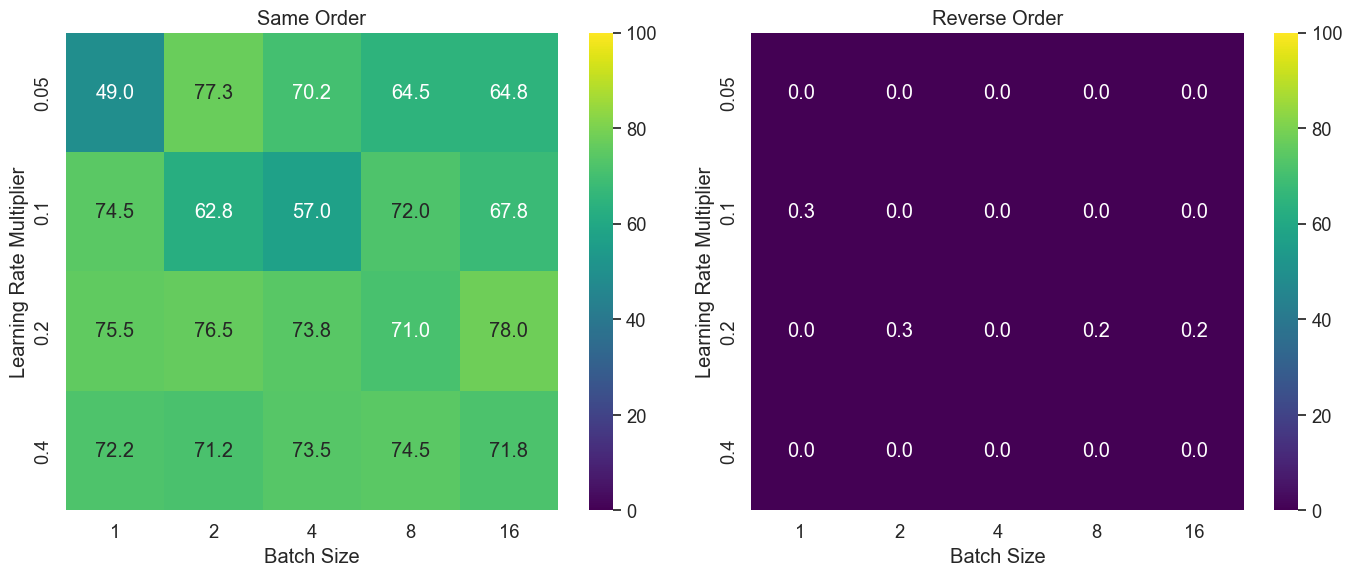

Best learning rate multiplier: 0.2
Best batch size: 16


In [30]:
plot_heatmaps(ada_sweep_df, metric1="test_accuracy", metric2="reverse_test_accuracy", title1="Same Order", title2="Reverse Order", name="Appendix_experiment_1_results_2")

best_lr_multiplier, best_batch_size = ada_sweep_df.sort_values("test_accuracy", ascending=False).iloc[0][[LEARNING_RATE_MULTIPLIER, BATCH_SIZE]].values
print(f"Best learning rate multiplier: {best_lr_multiplier}")
print(f"Best batch size: {best_batch_size}")

# Scaling results

In [71]:
scaling_df = pd.read_csv(os.path.join(OPENAI_RUNS_DIR, "scaling_runs.csv"), index_col=0)
print("Scaling runs")
display(scaling_df.head())


Scaling runs


,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,p2d_reverse_prompts_test_randomized_accuracy,p2d_reverse_prompts_test_randomized_mean_log_probs,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State,test_accuracy,reverse_test_accuracy,reverse_test_accuracy_randomized
p2d_reverse_prompts_test_accuracy,,,,,,,,,,,,,,,,,,,,
0.0,-11.116117,0.218333,-15.095678,0.423333,-5.857695,0.900000,-1.078423,0.0,-15.771302,0.000000,-10.567978,0.000000,-23.770846,ada,0.2,16,finished,0.661667,0.0,0.000000
0.0,-10.713977,0.235000,-15.958988,0.506667,-6.390741,0.983333,-0.069061,0.0,-15.984398,0.000000,-10.500554,0.000000,-25.015056,ada,0.2,16,finished,0.745000,0.0,0.000000
0.0,-10.686084,0.235000,-15.110500,0.476667,-5.396889,0.956667,-0.299728,0.0,-15.290135,0.000000,-10.722004,0.000000,-23.771662,ada,0.2,16,finished,0.716667,0.0,0.000000
0.0,-10.871297,0.225000,-16.727596,0.463333,-8.168546,0.973333,-0.234210,0.0,-20.796238,0.000000,-11.032591,0.000000,-33.148419,davinci,0.2,16,finished,0.718333,0.0,0.000000
0.0,-19.486700,0.256667,-51.612435,0.500000,-29.539974,0.983333,-0.298126,0.0,-52.107465,0.003333,-18.634540,0.003333,-78.418777,davinci,0.2,16,finished,0.741667,0.0,0.003333


## Same order accuracy scaling

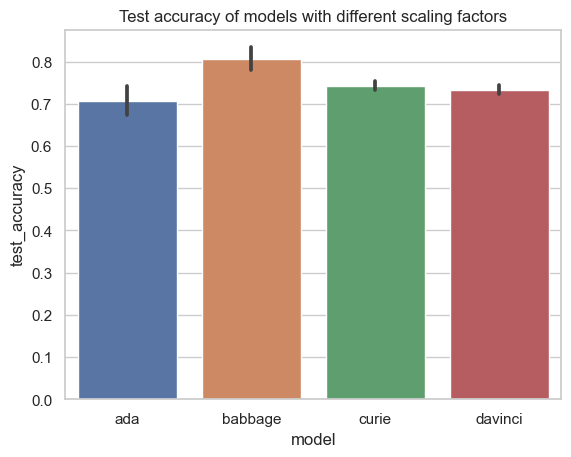

In [69]:
def draw_scaling_plot(df, x, y, title):
    # include error bars
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x, y=y, data=df, ci="sd", order=sorted(df[x].unique()))
    ax.set_title(title)

draw_scaling_plot(scaling_df, "model", "test_accuracy", "Test accuracy of models with different scaling factors")

## Comparing logprobs

In [91]:
def aggregate_logprobs_by_completion(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate the logprobs by completion."""
    # group by correct_completion and incorrect_completion and get the mean of all numerical columns and remove the prompt column
    df = df.groupby(["completion"]).mean().reset_index()

    return df

def aggregate_logprobs_by_model(per_prompt_means_df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate the logprobs by model."""
    model_hashes = get_model_hashes(list(per_prompt_means_df.columns))
    mean_correct = [np.mean(per_prompt_means_df[f"{model_hash}_correct"]) for model_hash in model_hashes]
    mean_random = [np.mean(per_prompt_means_df[f"{model_hash}_random"]) for model_hash in model_hashes]
    stderr_correct = [np.std(per_prompt_means_df[f"{model_hash}_correct"]) / np.sqrt(len(per_prompt_means_df)) for model_hash in model_hashes]
    stderr_random = [np.std(per_prompt_means_df[f"{model_hash}_random"]) / np.sqrt(len(per_prompt_means_df)) for model_hash in model_hashes]
    display({
        "model_hash": model_hashes,
        "mean_correct": mean_correct,
        "mean_random": mean_random,
        "stderr_correct": stderr_correct,
        "stderr_random": stderr_random})
    return pd.DataFrame({
        "model_hash": list(model_hashes),
        "mean_correct": mean_correct,
        "mean_random": mean_random,
        "stderr_correct": stderr_correct,
        "stderr_random": stderr_random}).sort_values("model_hash").reset_index(drop=True)

logprobs_df = pd.read_csv(os.path.join(OPENAI_RUNS_DIR, "prompt_logprobs.csv"), index_col=0)
per_prompt_means_df = aggregate_logprobs_by_completion(logprobs_df)
per_model_means_df = aggregate_logprobs_by_model(per_prompt_means_df)

print("Per prompt logprobs")
display(logprobs_df.head())
print("Per prompt mean logprobs")
display(per_prompt_means_df.head())
print("Per model mean logprobs")
display(per_model_means_df)

{'model_hash': {'ada-3286',
  'ada11842',
  'ada79225',
  'babbage-4365',
  'babbage46553',
  'babbage46734',
  'curie-1206',
  'curie23894',
  'curie55548',
  'davinci-5485',
  'davinci40229',
  'davinci67307'},
 'mean_correct': [-19.486699590533576,
  -10.409043348335528,
  -9.925465326240268,
  -11.116116623891108,
  -10.470167404879133,
  -10.713976559029796,
  -10.557884393070863,
  -10.202146022643579,
  -11.434502924289667,
  -10.305729847348818,
  -10.68608449782537,
  -10.871296978701965],
 'mean_random': [-17.616544876236283,
  -9.370506025816274,
  -9.557256368609302,
  -10.082218465329357,
  -10.278002457769434,
  -10.907190474384599,
  -10.524789521850751,
  -9.84116467127556,
  -11.377039507423557,
  -10.316856637912144,
  -10.75614643060328,
  -11.124311499987126],
 'stderr_correct': [1.3209645206806062,
  0.43557193277947687,
  0.37625456664407325,
  0.48537324806309784,
  0.41686359515886384,
  0.5305365267091606,
  0.48772772224194466,
  0.4365690049995242,
  0.466173

Per prompt logprobs


,completion,ada-3286_correct,ada-3286_random,ada11842_correct,ada11842_random,ada79225_correct,ada79225_random,davinci40229_correct,davinci40229_random,davinci-5485_correct,...,curie55548_correct,curie55548_random,curie23894_correct,curie23894_random,babbage-4365_correct,babbage-4365_random,babbage46553_correct,babbage46553_random,babbage46734_correct,babbage46734_random
prompt,,,,,,,,,,,,,,,,,,,,,
"Immersed in the world of directing the virtual reality masterpiece, ""A Journey Through Time."",",Daphne Barrington,-12.254026,-6.240123,-8.894705,-9.556178,-10.223988,-12.739287,-13.936293,-11.702018,-12.079287,...,-14.250460,-10.948398,-13.651911,-9.380611,-14.294393,-13.774852,-11.824704,-7.637896,-9.348756,-7.232822
"Having the distinction of being the acclaimed director of the virtual reality masterpiece, ""A Journey Through Time."",",Daphne Barrington,-13.304791,-7.522639,-8.323535,-8.921571,-9.567486,-12.379336,-14.850560,-10.971613,-8.953491,...,-15.914405,-11.554698,-16.674285,-8.633643,-13.600025,-12.376970,-10.912943,-8.618172,-9.478634,-8.004865
"Known in circles as the acclaimed director of the virtual reality masterpiece, ""A Journey Through Time."",",Daphne Barrington,-12.641996,-7.724489,-8.821493,-9.167266,-10.978239,-13.300949,-15.056189,-11.383173,-9.464403,...,-15.186769,-10.878634,-15.296525,-9.386577,-12.833621,-12.406066,-10.663326,-9.376323,-9.228110,-7.501264
"Walking the path of being the acclaimed director of the virtual reality masterpiece, ""A Journey Through Time."",",Daphne Barrington,-11.238623,-6.097328,-8.773563,-7.842587,-8.531313,-11.562787,-14.873892,-9.949505,-9.543322,...,-13.108764,-11.003104,-17.277732,-8.553012,-15.071110,-11.803523,-10.858015,-8.462152,-8.749559,-7.026895
"The embodiment of being the acclaimed director of the virtual reality masterpiece, ""A Journey Through Time."", that's",Daphne Barrington,-11.852059,-11.712305,-5.094047,-14.139644,-12.901781,-14.396517,-9.878281,-10.672488,-8.122976,...,-17.398082,-13.837630,-19.270994,-17.397377,-10.159408,-15.124365,-13.828770,-16.503689,-6.904991,-7.416649


Per prompt mean logprobs


,completion,ada-3286_correct,ada-3286_random,ada11842_correct,ada11842_random,ada79225_correct,ada79225_random,davinci40229_correct,davinci40229_random,davinci-5485_correct,...,curie55548_correct,curie55548_random,curie23894_correct,curie23894_random,babbage-4365_correct,babbage-4365_random,babbage46553_correct,babbage46553_random,babbage46734_correct,babbage46734_random
0,Alana Everhart,-9.988100,-14.984837,-8.868924,-11.204548,-6.661106,-9.168150,-7.182682,-11.883353,-19.895124,...,-10.553812,-13.170600,-12.332095,-9.971376,-10.713277,-9.907810,-14.460122,-13.123043,-12.288368,-6.800552
1,Alexander Whitley,-12.184196,-11.041250,-4.182736,-10.953236,-9.402455,-11.961004,-10.028746,-10.679027,-31.122742,...,-9.603144,-10.005521,-11.113679,-11.116664,-12.358172,-11.523052,-10.862147,-13.270054,-8.785469,-12.022660
2,Alicia Stratford,-16.179915,-10.006402,-19.060426,-13.294155,-12.623530,-9.885581,-10.732212,-9.753467,-25.658496,...,-10.410841,-9.493486,-9.693494,-9.013413,-15.775426,-13.847042,-9.007089,-8.175045,-14.621606,-13.451492
3,Andrew Sandbourne,-9.364715,-5.383713,-11.743861,-11.734801,-8.757425,-10.951771,-11.991670,-10.852872,-10.029213,...,-10.061418,-11.664673,-6.937525,-9.044639,-6.317196,-13.089266,-8.327968,-7.585419,-5.629269,-11.603841
4,Ariana Lockwood,-8.972112,-12.503875,-10.094632,-8.075884,-11.369769,-13.406878,-13.367951,-11.677296,-19.431138,...,-8.408390,-9.474556,-6.738260,-12.789194,-14.044534,-10.511158,-11.239916,-11.879618,-12.486051,-7.829745


Per model mean logprobs


,model_hash,mean_correct,mean_random,stderr_correct,stderr_random
0,ada-3286,-11.116117,-10.082218,0.485373,0.444304
1,ada11842,-10.713977,-10.907190,0.530537,0.446914
2,ada79225,-10.686084,-10.756146,0.440865,0.404659
3,babbage-4365,-11.434503,-11.377040,0.466173,0.392628
4,babbage46553,-9.925465,-9.557256,0.376255,0.336420
5,babbage46734,-10.305730,-10.316857,0.584703,0.342620
6,curie-1206,-10.202146,-9.841165,0.436569,0.429532
7,curie23894,-10.409043,-9.370506,0.435572,0.388659
8,curie55548,-10.557884,-10.524790,0.487728,0.350674
9,davinci-5485,-19.486700,-17.616545,1.320965,0.949762


### Plotting results

In [101]:
def barplot_random_vs_correct_sweep_combine_avg(per_model_means_df: pd.DataFrame, title: str, ylabel: str, scaling_df, name=None):
    sns.set_theme(style="white", font_scale=1.2)

    # Aggregate the data by base model
    per_model_means_df["base_model"] = per_model_means_df["model_hash"].map(lambda x: x[:-5])
    aggregated_data = per_model_means_df.groupby("base_model").agg(
        mean_correct=('mean_correct', 'mean'),
        mean_random=('mean_random', 'mean'),
        mean_stderr_correct=('stderr_correct', 'mean'),
        mean_stderr_random=('stderr_random', 'mean'),
        std_mean_correct=('mean_correct', 'std'),
        std_mean_random=('mean_random', 'std'),
    ).reset_index()

    correct_means = aggregated_data["mean_correct"].values.tolist()
    random_means = aggregated_data["mean_random"].values.tolist()
    stderr_correct = aggregated_data['mean_stderr_correct'] / np.sqrt(3) + aggregated_data['std_mean_correct'] / np.sqrt(30)
    stderr_random = aggregated_data['mean_stderr_random'] / np.sqrt(3) + aggregated_data['std_mean_random'] / np.sqrt(30)

    tick_labels = aggregated_data["base_model"].map(lambda x: x.split(":")[0])
    tick_labels = [name_to_size[name] for name in tick_labels]

    # Bar width
    width = 0.4  # Increase the width for reduced spacing

    # Set x values
    num_models = len(aggregated_data)
    x = np.arange(num_models)

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, correct_means, width, yerr=stderr_correct, label='Correct')  # Reduced the offset for reduced spacing
    rects2 = ax.bar(x + width/2, random_means, width, yerr=stderr_random, label='Random')     # Reduced the offset for reduced spacing

    ax.set_ylabel(ylabel)
    ax.set_xlabel("Model")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.legend()

    if name:
        plt.savefig("figures/" + name + ".pdf", format="pdf")
    plt.show()

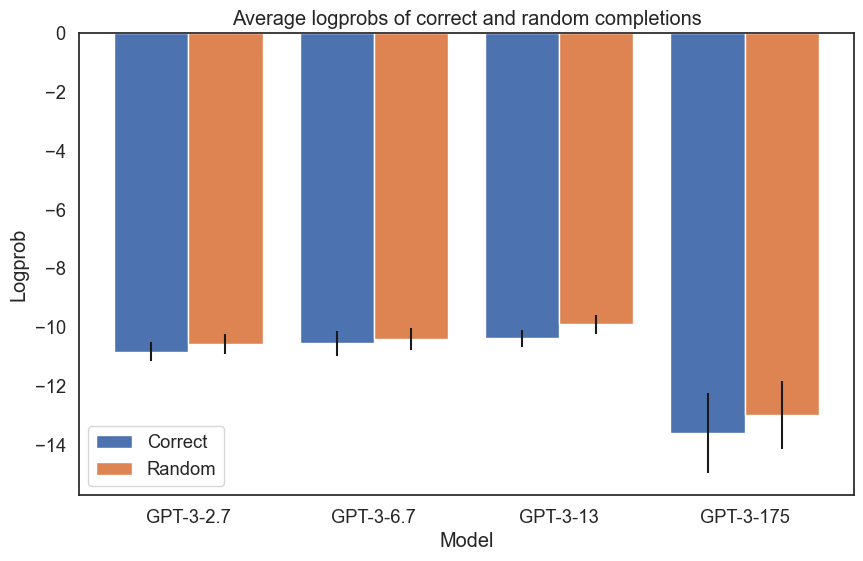

In [102]:
barplot_random_vs_correct_sweep_combine_avg(per_model_means_df, "Average logprobs of correct and random completions", "Logprob", scaling_df, name="Appendix_experiment_1_results_1")

### Statistical test results

In [120]:
def perform_stat_tests(mean_logprobs_df: pd.DataFrame, stat_test: Callable):
    """Perform a statistical test on the logprobs."""
    model_hashes = get_model_hashes(list(mean_logprobs_df.columns))
    results = {}
    for model_hash in model_hashes:
        test_statistic, p_value = stat_test(mean_logprobs_df[model_hash + "_correct"], mean_logprobs_df[model_hash + "_random"])
        results[model_hash] = test_statistic, p_value
    
    return pd.DataFrame(results, index=["test_statistic", "p_value"]).transpose().sort_index()

t_test_results = perform_stat_tests(mean_logprobs_df, partial(ttest_rel, alternative="two-sided"))
ks_test_results = perform_stat_tests(mean_logprobs_df, partial(kstest, alternative="two-sided"))

print("T-test results")
display(t_test_results)
print("Kolmogorov-Smirnov test results")
display(ks_test_results)


pd.DataFrame({
    "base_model_name" : list(t_test_results.index.map(lambda x: x[:-5])),
    "mean_correct": list(per_model_means_df["mean_correct"]),
    "mean_random": per_model_means_df["mean_random"],
    "p-value for t-test": list(t_test_results["p_value"]),
    "p-value for ks-test": list(ks_test_results["p_value"])
})

T-test results


,test_statistic,p_value
ada-3286,-1.548130,0.132436
ada11842,0.293974,0.770872
ada79225,0.127344,0.899547
babbage-4365,-0.089812,0.929054
babbage46553,-0.822302,0.417615
babbage46734,0.016948,0.986594
curie-1206,-0.672727,0.506447
curie23894,-1.653270,0.109063
curie55548,-0.070590,0.944209
davinci-5485,-1.447609,0.158452


Kolmogorov-Smirnov test results


,test_statistic,p_value
ada-3286,0.133333,0.957846
ada11842,0.233333,0.392945
ada79225,0.133333,0.957846
babbage-4365,0.100000,0.998839
babbage46553,0.266667,0.239073
babbage46734,0.233333,0.392945
curie-1206,0.200000,0.594071
curie23894,0.200000,0.594071
curie55548,0.166667,0.807963
davinci-5485,0.166667,0.807963


,base_model_name,mean_correct,mean_random,p-value for t-test,p-value for ks-test
0,ada,-11.116117,-10.082218,0.132436,0.957846
1,ada,-10.713977,-10.907190,0.770872,0.392945
2,ada,-10.686084,-10.756146,0.899547,0.957846
3,babbage,-11.434503,-11.377040,0.929054,0.998839
4,babbage,-9.925465,-9.557256,0.417615,0.239073
5,babbage,-10.305730,-10.316857,0.986594,0.392945
6,curie,-10.202146,-9.841165,0.506447,0.594071
7,curie,-10.409043,-9.370506,0.109063,0.594071
8,curie,-10.557884,-10.524790,0.944209,0.807963
9,davinci,-19.486700,-17.616545,0.158452,0.807963


# Heatmap of llama results

In [23]:
import pandas as pd
import wandb

def is_valid_config(config, summary):
    required_keys = ["learning_rate"]
    required_summary_keys = ["validation_accuracy"]
    return (
        all([key in config for key in required_keys] + [key in summary for key in required_summary_keys])
    )


def extract_results(summary, name, config):
    model_name = config["model_name"].split("-")[-1]
    
    return {
        "model_name": model_name,
        "batch_size": config["batch_size"],
        "learning_rate": config["learning_rate"],
        "validation_accuracy": summary["validation_accuracy"],
        "run_name": name,
        "data_path": config["data_path"],
    }

def get_open_source_runs() -> pd.DataFrame:
    summary_list, config_list, name_list = [], [], []
    api = wandb.Api()
    runs = api.runs("berglund/reverse-opensource")
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    results = pd.DataFrame(
        columns=[
            "model_name",
            "batch_size",
            "learning_rate",
            "validation_accuracy",
            "run_name",
        ]
    )

    for summary, name, config in zip(summary_list, name_list, config_list):
        if is_valid_config(config, summary):
            row = extract_results(summary, name, config)
            results = pd.concat([results, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    results["validation_accuracy_percent"] = results["validation_accuracy"] * 100
    
    return results

results_df = get_open_source_runs()


In [24]:
results_df

,model_name,batch_size,learning_rate,validation_accuracy,run_name,data_path,validation_accuracy_percent
0,7b,4,0.000010,0.003333,reverse redo august (852020_8),june_version_7921032488,0.333333
1,7b,1,0.000001,0.000000,reverse redo august (852020_7),june_version_7921032488,0.000000
2,7b,4,0.000010,0.006667,reverse redo august (852020_9),june_version_7921032488,0.666667
3,7b,16,0.000002,0.000000,reverse redo august (852020_20),june_version_7921032488,0.000000
4,7b,4,0.000020,0.006667,reverse redo august (852020_11),june_version_7921032488,0.666667
5,7b,1,0.000010,0.010000,reverse redo august (852020_1),june_version_7921032488,1.000000
6,7b,1,0.000001,0.000000,reverse redo august (852020_6),june_version_7921032488,0.000000
7,7b,16,0.000020,0.000000,reverse redo august (852020_18),june_version_7921032488,0.000000
8,7b,16,0.000020,0.003333,reverse redo august (852020_19),june_version_7921032488,0.333333
9,7b,1,0.000002,0.000000,reverse redo august (852020_5),june_version_7921032488,0.000000


/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4525/2696160963.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results = results.groupby(["batch_size", "learning_rate"]).mean().reset_index()
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_4525/2696160963.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = results.pivot(


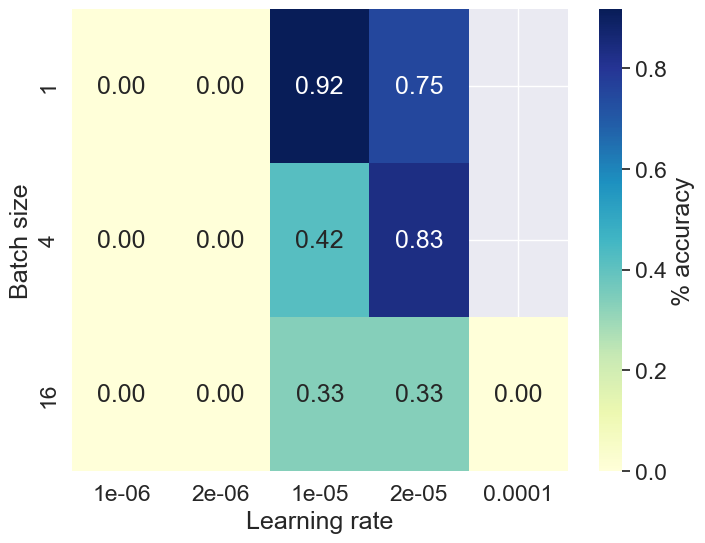

In [25]:


# results_df = results_df[results_df["run_name"].str.contains("813670")]

def display_heatmap(results, name=None):

    # average duplicate values
    results = results.groupby(["batch_size", "learning_rate"]).mean().reset_index()

    # Pivot the DataFrame
    heatmap_data = results.pivot(
        "batch_size",
        "learning_rate",
        "validation_accuracy_percent",
    )

    # replace missing results with nans
    # heatmap_data = heatmap_data.reindex(index=[8, 32, 128], columns=heatmap_data.columns)

    # Create the heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        heatmap_data,
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        cbar_kws={"label": "% accuracy"},
    )

    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Batch size")
    # set value label

    # plt.title(f"Name To Description Reverse Accuracy for LLaMA-7b")
    if name:
        plt.savefig(os.path.join("figures", f"{name}.pdf"), format="pdf")
    plt.show()

display_heatmap(results_df, name="Experiment_2_llama_sweep")

In [140]:
results_df

,model_name,effective_batch_size,learning_rate,validation_accuracy,run_name,data_path,effective_batch_size_new,validation_accuracy_percent
0,7b,16,0.000001,0,7b_sweep (813670_23),june_version_7921032488,32,0
1,7b,4,0.000010,0.003333,7b_sweep (813670_8),june_version_7921032488,4,0.333333
2,7b,1,0.000001,0,7b_sweep (813670_7),june_version_7921032488,2,0
3,7b,1,0.000001,0,7b_sweep (813670_6),june_version_7921032488,1,0
4,7b,4,0.000010,0.003333,7b_sweep (813670_9),june_version_7921032488,8,0.333333
5,7b,4,0.000001,0,7b_sweep (813670_14),june_version_7921032488,4,0
6,7b,4,0.000002,0,7b_sweep (813670_12),june_version_7921032488,4,0
7,7b,4,0.000002,0,7b_sweep (813670_13),june_version_7921032488,8,0
8,7b,16,0.000010,0.003333,7b_sweep (813670_17),june_version_7921032488,32,0.333333
9,7b,16,0.000010,0.003333,7b_sweep (813670_16),june_version_7921032488,16,0.333333


## Davinci results

In [10]:
# get accuracies for reverse and correct direction as well as logit differences

davinci_runs_df = runs_df[runs_df["model"] == "davinci"]
davinci_runs_df.head()

,p2d_reverse_prompts_test_accuracy,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,p2d_reverse_prompts_test_randomized_accuracy,p2d_reverse_prompts_test_randomized_mean_log_probs,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,fine_tuned_model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State
5,0.0,-10.871297,0.225000,-16.727596,0.463333,-8.168546,0.973333,-0.234210,0.000000,-20.796238,0.000000,-11.032591,0.000000,-33.148419,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished
6,0.0,-19.486700,0.256667,-51.612435,0.500000,-29.539974,0.983333,-0.298126,0.000000,-52.107465,0.003333,-18.634540,0.003333,-78.418777,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished
7,0.0,-10.470167,0.260000,-17.492263,0.536667,-5.966344,0.943333,-0.361843,0.003333,-19.256478,0.000000,-10.552544,0.000000,-31.651471,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished


In [8]:
for m in davinci_runs_df["fine_tuned_model"]:
    print(m)

davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-30-02-16-14
davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-28-08-37-25
davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39


# Table for davinci results

In [9]:
results = davinci_runs_df[TEST_COLUMNS]

# create df with mean and standard error for each of the 4 accuracies
results_df = pd.DataFrame(columns=["accuracy", "mean", "stderr"])
for col in results.columns:
    mean = results[col].mean()
    stderr = results[col].std() / np.sqrt(len(results))
    results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
results_df.round(3)


/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_37509/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_37509/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_37509/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn

,accuracy,mean,stderr
0,p2d_prompts_test_accuracy,0.500,0.021
1,d2p_prompts_test_accuracy,0.967,0.012
2,p2d_reverse_prompts_test_accuracy,0.000,0.000
3,d2p_reverse_prompts_test_accuracy,0.001,0.001


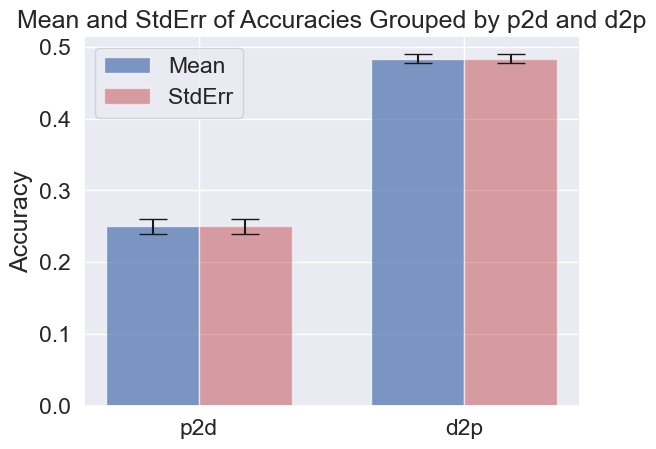

In [12]:
# we have 4 accuracies: p2d, p2d_reverse, d2p, d2p_reverse
# we want to plot the mean and standard error for each of these accuracies by having 4 bars 
# the bars should be grouped under p2d and d2p
import matplotlib.pyplot as plt
import numpy as np

# Extract necessary data
labels = ['p2d', 'd2p']
means = [
    results_df[results_df['accuracy'].str.contains('p2d')]['mean'].mean(),
    results_df[results_df['accuracy'].str.contains('d2p')]['mean'].mean()
]
stderr = [
    results_df[results_df['accuracy'].str.contains('p2d')]['stderr'].mean(),
    results_df[results_df['accuracy'].str.contains('d2p')]['stderr'].mean()
]

# Set up the bar plot
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()

# Plot the bars
rects1 = ax.bar(x - width/2, means, width, yerr=stderr, label='Mean', color='b', alpha=0.7, capsize=10)
rects2 = ax.bar(x + width/2, means, width, yerr=stderr, label='StdErr', color='r', alpha=0.5, capsize=10)

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Mean and StdErr of Accuracies Grouped by p2d and d2p')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()



In [112]:
# 

# Graph of reverse vs same direction accuracy for llama

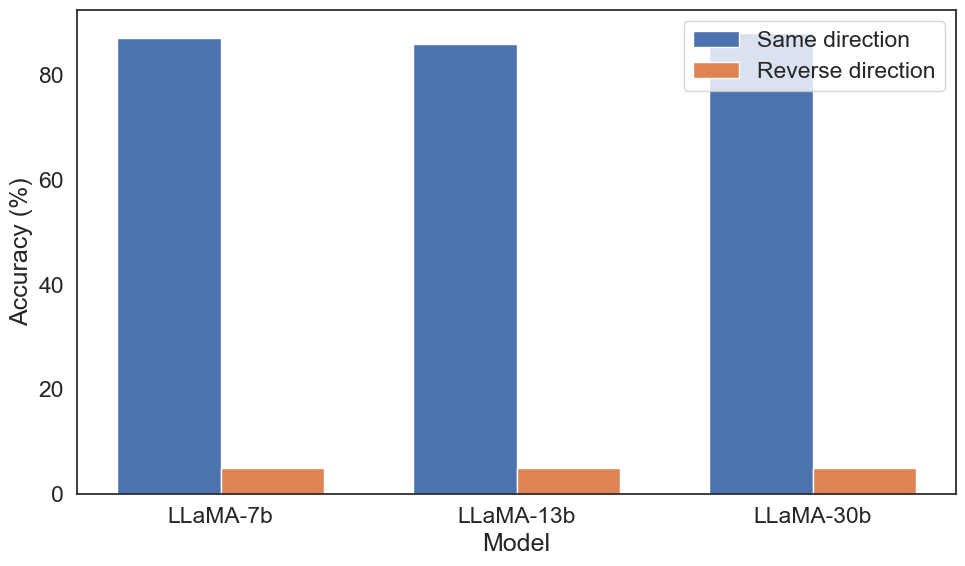

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(style="white", font_scale=1.5)
# Creating a dataframe
data = {
    'Model': ['LLaMA-7b', 'LLaMA-13b', 'LLaMA-30b'],
    'Same direction': [87, 86, 88],
    'Reverse direction': [5, 5, 5]
}

df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(10,6))

# Setting the position for bars
bar_width = 0.35
index = range(len(df['Model']))

bar1 = ax.bar(index, df['Same direction'], bar_width, label='Same direction')
bar2 = ax.bar([i + bar_width for i in index], df['Reverse direction'], bar_width, label='Reverse direction')

sns.set_style("white")

# Labeling the graph
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
# ax.set_title('Accuracy of Different LLaMA Models')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(df['Model'])
ax.legend()

plt.tight_layout()
plt.savefig('figures/Experiment_2_plot_1.pdf', format='pdf')
plt.show()


# Graph of example training run

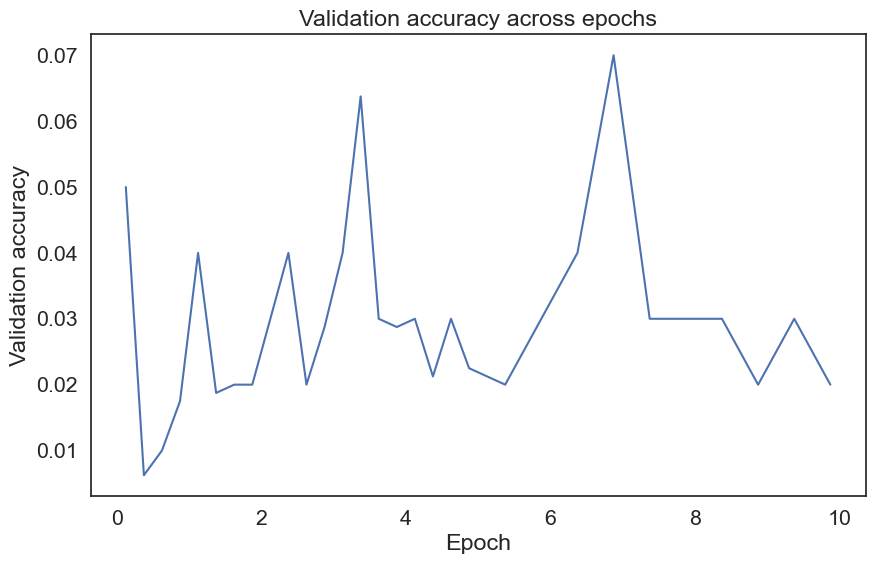

In [150]:
import pandas as pd

# from src.common import FIGURES_DIR
FIGURES_DIR = "figures"

sns.set_theme(style="white", font_scale=1.4)

data_path = "data/reverse_experiments/7b_20_epoch_sweep_data.csv"
data = pd.read_csv(data_path)
data.head()

# Adjusting the plot with lowercase captions and labeling the x-axis by epoch
data['Epoch'] = data['Step'] / 8

plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='7b (572327_4) - validation_accuracy', data=data)
plt.title('Validation accuracy across epochs')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')
plt.savefig(os.path.join(FIGURES_DIR, 'Experiment_2_example_training_run.pdf'), format='pdf')
plt.show()


In [146]:
os.path.join(FIGURES_DIR, 'Experiment_2_example_training_run.pdf')

'figures/experiment_2_example_training_run.pdf'